In [1]:
%pip install jupytext

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
%ls

efficientnet-asnet.ipynb          mobilenetv3-asnet-v1.ipynb
mobilenetv3-asnet-best.ipynb      mobilenetv3-asnetv2.ipynb
mobilenetv3-asnet-slow-ver.ipynb  vgg16-asnet.ipynb


In [4]:
!jupytext --to py mobilenetv3-asnet-best.ipynb

[jupytext] Reading mobilenetv3-asnet-best.ipynb in format ipynb
[jupytext] Writing mobilenetv3-asnet-best.py


# 1. Import needed libraries

In [ ]:
# ------------------------------
# 1. Import needed libraries
# ------------------------------

# ---------- Basic Python imports ----------
import os
import time
import warnings

# ---------- Image Processing ----------
from PIL import Image

# ---------- Data Analysis & Visualization ----------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- Machine Learning ----------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# ---------- Deep Learning & TensorFlow ----------
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    BatchNormalization,
    Dense,
    Dropout,
    Conv2D,
    Multiply,
    GlobalAveragePooling2D,
    Reshape,
    Layer,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras import Input
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# ---------- Settings ----------
warnings.filterwarnings("ignore")

In [ ]:
# GPU/CPU detection
print("Checking available devices...")
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices("GPU")
        print(f"Physical GPUs: {len(gpus)}, Logical GPUs: {len(logical_gpus)}")
        strategy = tf.distribute.MirroredStrategy()
        print(f"Running on {len(strategy.extended.worker_devices)} GPU(s)")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        strategy = tf.distribute.get_strategy()
        print("Running on CPU")
else:
    strategy = tf.distribute.get_strategy()
    print("No GPU detected. Running on CPU")

print("REPLICAS: ", strategy.num_replicas_in_sync)

Checking available devices...
Physical GPUs: 1, Logical GPUs: 1
Running on 1 GPU(s)
REPLICAS:  1


# 2. Preprocessing

## 2.1 Load data

In [ ]:
def create_dataset_df(path):
    """
    Create a DataFrame containing image paths and their corresponding classes.

    Args:
        path (str): Path to the dataset directory

    Returns:
        pd.DataFrame: DataFrame with columns 'Class Path' and 'Class'
    """
    classes, class_paths = zip(
        *[
            (label, os.path.join(path, label, image))
            for label in os.listdir(path)
            if os.path.isdir(os.path.join(path, label))
            for image in os.listdir(os.path.join(path, label))
        ]
    )

    return pd.DataFrame({"Class Path": class_paths, "Class": classes})

In [ ]:
tr_df = create_dataset_df("/kaggle/input/Training")

In [5]:
tr_df

Class Path      Class
0     /kaggle/input/Training/pituitary/Tr-pi_0532.jpg  pituitary
1     /kaggle/input/Training/pituitary/Tr-pi_0282.jpg  pituitary
2     /kaggle/input/Training/pituitary/Tr-pi_1401.jpg  pituitary
3     /kaggle/input/Training/pituitary/Tr-pi_0914.jpg  pituitary
4     /kaggle/input/Training/pituitary/Tr-pi_0691.jpg  pituitary
...                                               ...        ...
5707     /kaggle/input/Training/glioma/Tr-gl_0578.jpg     glioma
5708     /kaggle/input/Training/glioma/Tr-gl_0659.jpg     glioma
5709     /kaggle/input/Training/glioma/Tr-gl_0253.jpg     glioma
5710     /kaggle/input/Training/glioma/Tr-gl_0492.jpg     glioma
5711     /kaggle/input/Training/glioma/Tr-gl_1037.jpg     glioma

[5712 rows x 2 columns]

In [ ]:
ts_df = create_dataset_df("/kaggle/input/Testing")

In [7]:
ts_df

Class Path      Class
0     /kaggle/input/Testing/pituitary/Te-pi_0059.jpg  pituitary
1     /kaggle/input/Testing/pituitary/Te-pi_0024.jpg  pituitary
2     /kaggle/input/Testing/pituitary/Te-pi_0232.jpg  pituitary
3     /kaggle/input/Testing/pituitary/Te-pi_0286.jpg  pituitary
4     /kaggle/input/Testing/pituitary/Te-pi_0233.jpg  pituitary
...                                              ...        ...
1306     /kaggle/input/Testing/glioma/Te-gl_0107.jpg     glioma
1307     /kaggle/input/Testing/glioma/Te-gl_0288.jpg     glioma
1308     /kaggle/input/Testing/glioma/Te-gl_0108.jpg     glioma
1309   /kaggle/input/Testing/glioma/Te-glTr_0004.jpg     glioma
1310     /kaggle/input/Testing/glioma/Te-gl_0250.jpg     glioma

[1311 rows x 2 columns]

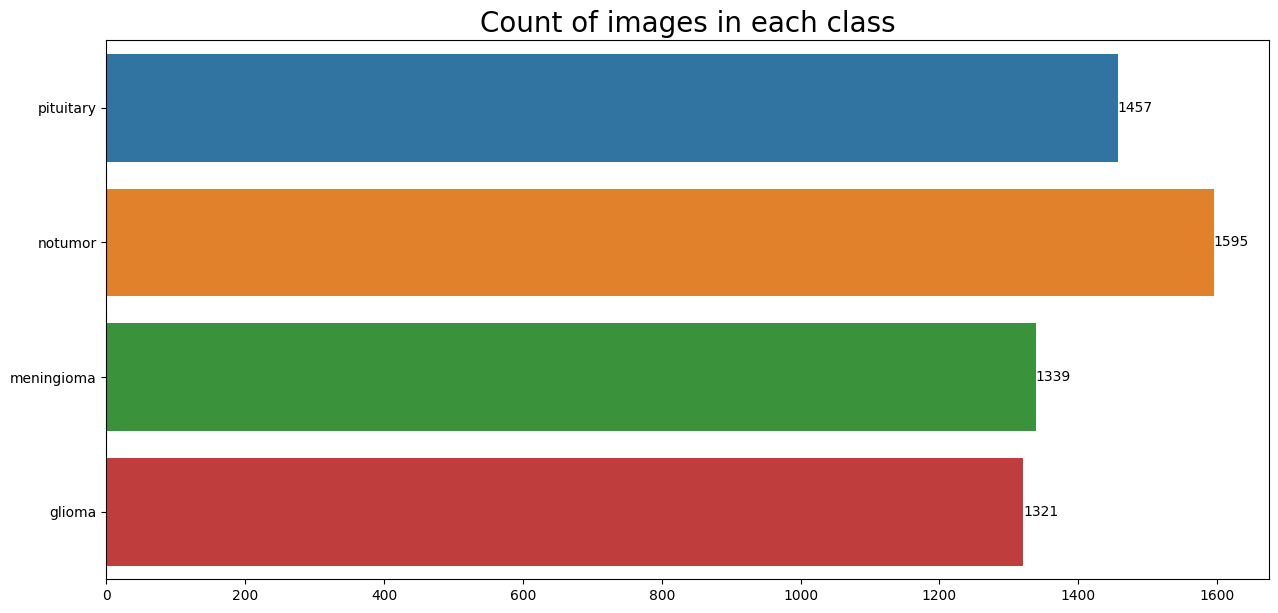

In [ ]:
# Count of images in each class in train data
plt.figure(figsize=(15, 7))
ax = sns.countplot(data=tr_df, y=tr_df["Class"])

plt.xlabel("")
plt.ylabel("")
plt.title("Count of images in each class", fontsize=20)
ax.bar_label(ax.containers[0])

plt.show()

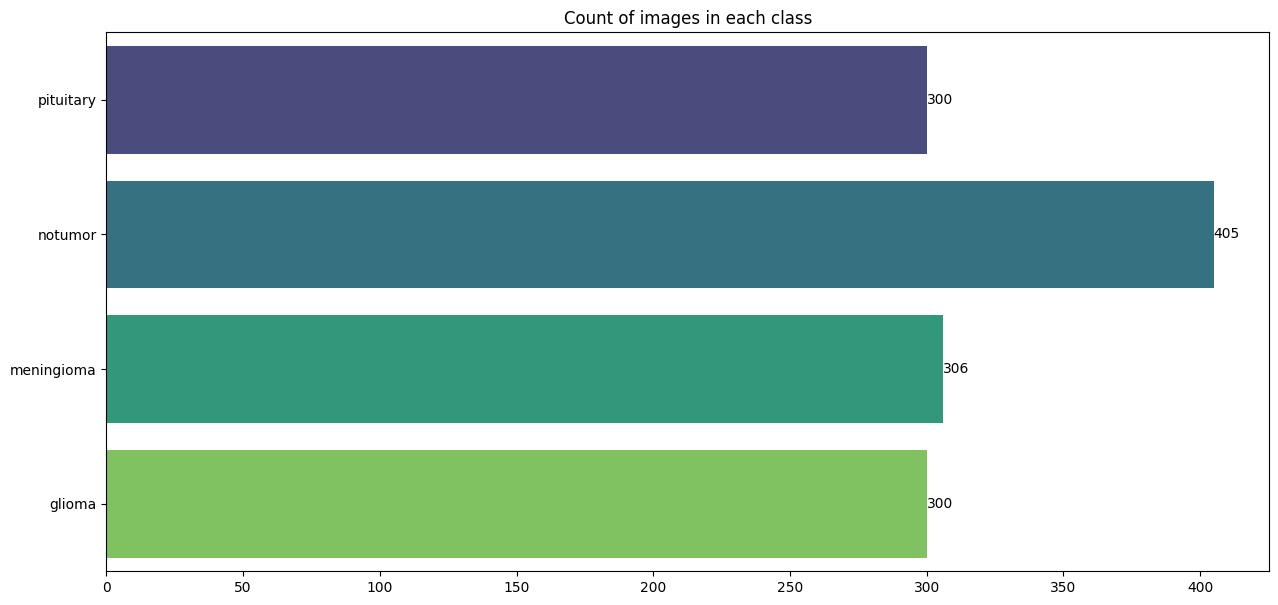

In [ ]:
# Count each class in test data
plt.figure(figsize=(15, 7))
ax = sns.countplot(y=ts_df["Class"], palette="viridis")

ax.set(xlabel="", ylabel="", title="Count of images in each class")
ax.bar_label(ax.containers[0])

plt.show()

## 2.2 Split data into train, test, valid

In [ ]:
valid_df, ts_df = train_test_split(
    ts_df, train_size=0.5, random_state=20, stratify=ts_df["Class"]
)

In [11]:
valid_df

Class Path       Class
1297      /kaggle/input/Testing/glioma/Te-gl_0227.jpg      glioma
723   /kaggle/input/Testing/meningioma/Te-me_0269.jpg  meningioma
61     /kaggle/input/Testing/pituitary/Te-pi_0210.jpg   pituitary
778   /kaggle/input/Testing/meningioma/Te-me_0013.jpg  meningioma
1120    /kaggle/input/Testing/glioma/Te-glTr_0008.jpg      glioma
...                                               ...         ...
1070      /kaggle/input/Testing/glioma/Te-gl_0293.jpg      glioma
554      /kaggle/input/Testing/notumor/Te-no_0054.jpg     notumor
1284      /kaggle/input/Testing/glioma/Te-gl_0298.jpg      glioma
899   /kaggle/input/Testing/meningioma/Te-me_0297.jpg  meningioma
626      /kaggle/input/Testing/notumor/Te-no_0351.jpg     notumor

[655 rows x 2 columns]

## 2.3 Data Augmentation and Generators (Data Preprocessing)

In [ ]:
BATCH_SIZE = 32 * strategy.num_replicas_in_sync
IMAGE_SIZE = (224, 224)


def prepare_data(tr_df, ts_df):
    def process_image(file_path):
        img = Image.open(file_path)
        # Convert grayscale to RGB if needed
        if img.mode != "RGB":
            img = img.convert("RGB")
        img = img.resize(IMAGE_SIZE)
        return np.array(img)

    # Convert DataFrame to numpy arrays
    X = (
        np.array([process_image(f) for f in tr_df["Class Path"]], dtype=np.float32)
        / 255.0
    )
    y = pd.get_dummies(tr_df["Class"]).values

    X_test = (
        np.array([process_image(f) for f in ts_df["Class Path"]], dtype=np.float32)
        / 255.0
    )
    y_test = pd.get_dummies(ts_df["Class"]).values

    return X, y, X_test, y_test


def get_augmentation():
    return ImageDataGenerator(
        rescale=1 / 255,
        brightness_range=(0.9, 1.1),
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode="reflect",
    )


_gen = get_augmentation()

ts_gen = ImageDataGenerator(rescale=1 / 255)


tr_gen = _gen.flow_from_dataframe(
    tr_df,
    x_col="Class Path",
    y_col="Class",
    batch_size=BATCH_SIZE,
    target_size=IMAGE_SIZE,
)

valid_gen = _gen.flow_from_dataframe(
    valid_df,
    x_col="Class Path",
    y_col="Class",
    batch_size=BATCH_SIZE,
    target_size=IMAGE_SIZE,
)

ts_gen = ts_gen.flow_from_dataframe(
    ts_df,
    x_col="Class Path",
    y_col="Class",
    batch_size=BATCH_SIZE,
    target_size=IMAGE_SIZE,
    shuffle=False,
)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


## 2.4 Getting samples from data

In [ ]:
# Get the class dictionary and classes list
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())

# Get a batch of images
images, labels = next(ts_gen)

# Calculate grid dimensions based on number of images
n_images = len(images)
grid_size = int(np.ceil(np.sqrt(n_images)))  # Make a square grid

# Create the plot
plt.figure(figsize=(20, 20))

# Show all images in a dynamic grid (uncomment to use)
for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(grid_size, grid_size, i + 1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color="k", fontsize=15)
    plt.axis("off")

plt.tight_layout()
plt.show()

# 3. Building Deep Learning Model

In [ ]:
class SAM(Model):
    def __init__(self, filters):
        super(SAM, self).__init__()
        self.filters = filters
        # Three sequential 3x3 convs as specified
        self.conv1 = Conv2D(
            self.filters // 4,
            3,
            activation="relu",
            padding="same",
            kernel_initializer="he_normal",
        )
        self.conv2 = Conv2D(
            self.filters // 4,
            3,
            activation="relu",
            padding="same",
            kernel_initializer="he_normal",
        )
        self.conv3 = Conv2D(
            self.filters // 4,
            3,
            activation="relu",
            padding="same",
            kernel_initializer="he_normal",
        )
        # Dimension reduction conv
        self.conv4 = Conv2D(
            self.filters // 4, 1, activation="relu", kernel_initializer="he_normal"
        )
        # Attention branch convs
        self.W1 = Conv2D(1, 1, activation="sigmoid", kernel_initializer="he_normal")
        self.W2 = Conv2D(1, 1, activation="sigmoid", kernel_initializer="he_normal")

    def call(self, inputs):
        # Sequential convolutions
        out1 = self.conv3(self.conv2(self.conv1(inputs)))
        # Dimension reduction
        out2 = self.conv4(inputs)

        # 2x2 max pooling branch
        pool1 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(out2)
        # Bilinear upsampling to original size
        upsample1 = tf.image.resize(pool1, size=tf.shape(out2)[1:3], method="bilinear")
        # Apply 1x1 conv with sigmoid
        attention1 = self.W1(upsample1)

        # 4x4 max pooling branch
        pool2 = tf.keras.layers.MaxPool2D(pool_size=(4, 4))(out2)
        # Bilinear upsampling to original size
        upsample2 = tf.image.resize(pool2, size=tf.shape(out2)[1:3], method="bilinear")
        # Apply 1x1 conv with sigmoid
        attention2 = self.W2(upsample2)

        # Sum the two attention maps
        attention_sum = attention1 + attention2

        # Apply attention to features via element-wise multiplication
        attended_features = Multiply()([out1, attention_sum])

        # Add to dimension-reduced input (residual connection)
        y = attended_features + out2
        return y


class CAM(Model):
    def __init__(self, filters, reduction_ratio=16):
        super(CAM, self).__init__()
        self.filters = filters
        # Conv block to process input features
        self.conv1 = Conv2D(
            self.filters // 4,
            3,
            activation="relu",
            padding="same",
            kernel_initializer="he_normal",
        )
        self.conv2 = Conv2D(
            self.filters // 4,
            3,
            activation="relu",
            padding="same",
            kernel_initializer="he_normal",
        )
        self.conv3 = Conv2D(
            self.filters // 4,
            3,
            activation="relu",
            padding="same",
            kernel_initializer="he_normal",
        )
        # Dimension reduction conv
        self.conv4 = Conv2D(
            self.filters // 4, 1, activation="relu", kernel_initializer="he_normal"
        )
        # Squeeze-and-Excitation components
        self.gpool = GlobalAveragePooling2D()
        self.fc1 = Dense(
            self.filters // (4 * reduction_ratio), activation="relu", use_bias=False
        )
        self.fc2 = Dense(self.filters // 4, activation="sigmoid", use_bias=False)

    def call(self, inputs):
        # Process input through conv block
        out1 = self.conv3(self.conv2(self.conv1(inputs)))
        # Dimension reduction
        out2 = self.conv4(inputs)

        # Squeeze-and-Excitation: squeeze spatial dimensions
        channel_attention = self.gpool(out2)
        # Dimension reduction in channel-wise fully connected layer
        channel_attention = self.fc1(channel_attention)
        # Dimension increase with sigmoid activation
        channel_attention = self.fc2(channel_attention)
        # Reshape to proper dimensions for broadcasting
        channel_attention = Reshape((1, 1, self.filters // 4))(channel_attention)

        # Apply channel attention via element-wise multiplication
        recalibrated = Multiply()([out1, channel_attention])

        # Add residual connection with dimension-reduced input
        y = recalibrated + out2
        return y


class SynergyModule(Model):
    def __init__(self, filters):
        super(SynergyModule, self).__init__()
        self.filters = filters
        # Trainable scaling parameters
        self.alpha = tf.Variable(0.5, trainable=True, dtype=tf.float32, name="alpha")
        self.beta = tf.Variable(0.5, trainable=True, dtype=tf.float32, name="beta")
        # Integration components
        self.conv = Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")
        self.bn = BatchNormalization()

    def call(self, inputs):
        # Unpack inputs (spatial and channel attention outputs)
        spatial_features, channel_features = inputs

        # Scale each pathway with trainable parameters
        scaled_spatial = tf.multiply(spatial_features, self.alpha)
        scaled_channel = tf.multiply(channel_features, self.beta)

        # Sum the scaled features
        combined = scaled_spatial + scaled_channel

        # Apply convolution and batch normalization
        output = self.conv(combined)
        output = self.bn(output)

        return output


class ResizeLayer(Layer):
    def __init__(self, target_height, target_width, **kwargs):
        super(ResizeLayer, self).__init__(**kwargs)
        self.target_height = target_height
        self.target_width = target_width

    def call(self, inputs):
        return tf.image.resize(inputs, (self.target_height, self.target_width))


def adjust_feature_map(x, target_shape):
    _, h, w, _ = target_shape
    current_h, current_w = x.shape[1:3]
    if current_h != h or current_w != w:
        resize_layer = ResizeLayer(h, w)
        return resize_layer(x)
    return x


# AS_Net with MobileNetV3Large encoder
def AS_Net(
    encoder="mobilenet", input_size=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), fine_tune_at=None
):
    inputs = Input(input_size)
    print(f"CURRENT ENCODER: {encoder}")

    if encoder == "mobilenet":
        # Load MobileNetV3Large with wider channels
        ENCODER = MobileNetV3Large(
            weights="imagenet", include_top=False, input_shape=input_size
        )  # Use alpha>1 for wider networks

        # Freeze early layers, unfreeze later layers
        if fine_tune_at is not None:
            for layer in ENCODER.layers[:fine_tune_at]:
                layer.trainable = False
            for layer in ENCODER.layers[fine_tune_at:]:
                layer.trainable = True

        # Extract features from more appropriate layers for medical imaging
        layer_indices = [20, 80, 120, 150, 183]  # Adjust based on your model inspection
    else:
        raise ValueError(
            "Unsupported encoder type. Only 'mobilenet' is supported in this case."
        )

    # Get the output layers dynamically
    encoder_outputs = []
    for i in layer_indices:
        try:
            layer = ENCODER.get_layer(index=i)
            encoder_outputs.append(
                Model(inputs=ENCODER.inputs, outputs=layer.output)(inputs)
            )
        except:
            print(f"Layer index {i} out of range, skipping")

    # Make sure we have at least one valid output
    if not encoder_outputs:
        raise ValueError("No valid layer indices provided")

    # Get the final encoder output that will be processed by the attention paths
    final_encoder_output = encoder_outputs[-1]
    filters = final_encoder_output.shape[-1]

    # Create enhanced features by integrating multi-scale information
    enhanced_features = final_encoder_output

    # Integrate features from earlier layers for better detail preservation
    for feat in reversed(encoder_outputs[:-1]):
        # Resize and merge features
        resized_feat = adjust_feature_map(feat, final_encoder_output.shape)
        # Use concatenation followed by 1x1 conv to combine features
        enhanced_features = tf.keras.layers.Concatenate()(
            [enhanced_features, resized_feat]
        )

    # Use 1x1 convolution to reduce channel dimensions back to original size
    enhanced_features = Conv2D(filters, 1, activation="relu", padding="same")(
        enhanced_features
    )

    # Create two parallel attention paths from the enhanced features
    # Spatial Attention Path
    SAM_output = SAM(filters=filters)(enhanced_features)

    # Channel Attention Path
    CAM_output = CAM(filters=filters)(enhanced_features)

    # Apply Synergy Module to combine attention outputs
    synergy_output = SynergyModule(filters=filters)([SAM_output, CAM_output])

    # Simplify the final layers
    final_layers = Sequential(
        [
            Conv2D(128, 3, activation="relu", padding="same"),
            BatchNormalization(),
            GlobalAveragePooling2D(),
            Dense(256, activation="relu"),
            Dropout(0.5),  # Increased dropout for better regularization
            Dense(4, activation="softmax"),
        ]
    )

    output = final_layers(synergy_output)

    model = Model(inputs=inputs, outputs=output)
    return model


# Create and compile the model
with strategy.scope():
    model = AS_Net(encoder="mobilenet", fine_tune_at=50)  # Unfreeze more layers

    # Use a more stable learning rate schedule
    initial_learning_rate = 5e-5  # Start with a lower learning rate

    # Use a more robust optimizer
    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=initial_learning_rate,
        weight_decay=1e-5,  # Add weight decay to prevent overfitting
    )

    # Use a weighted loss function for class imbalance
    def weighted_categorical_crossentropy(class_weights):
        def loss(y_true, y_pred):
            y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
            loss = -tf.reduce_sum(
                tf.multiply(
                    y_true * tf.math.log(y_pred),
                    tf.constant(class_weights, dtype=tf.float32),
                ),
                axis=-1,
            )
            return loss

        return loss

    # Calculate class weights
    class_weights = compute_class_weight(
        "balanced", classes=np.unique(tr_gen.classes), y=tr_gen.classes
    )

    model.compile(
        optimizer=optimizer,
        loss=weighted_categorical_crossentropy(class_weights),
        metrics=[
            "accuracy",
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
            tf.keras.metrics.AUC(name="auc"),
        ],
    )

model.summary()

CURRENT ENCODER: mobilenet
12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_3 (Functional) │ (None, 1, 1, 672)      │      1,127,712 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_4 (Functional) │ (None, 7, 7, 160)      │      2,838,912 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resize_layer              │ (None, 7, 7, 672)      │              0 │ functional_3[0][0]     │
│ (ResizeLayer)             │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_2 (Functional) │ (None, 1, 1, 480)      │        360,400 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 7, 7, 832)      │              0 │ functional_4[0][0],    │
│                           │                        │                │ resize_layer[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resize_layer_1            │ (None, 7, 7, 480)      │              0 │ functional_2[0][0]     │
│ (ResizeLayer)             │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_1 (Functional) │ (None, 14, 14, 240)    │         77,024 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 7, 7, 1312)     │              0 │ concatenate[0][0],     │
│ (Concatenate)             │                        │                │ resize_layer_1[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resize_layer_2            │ (None, 7, 7, 240)      │              0 │ functional_1[0][0]     │
│ (ResizeLayer)             │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional (Functional)   │ (None, 56, 56, 72)     │          6,496 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 7, 7, 1552)     │              0 │ concatenate_1[0][0],   │
│ (Concatenate)             │                        │                │ resize_layer_2[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resize_layer_3            │ (None, 7, 7, 72)       │              0 │ functional[0][0]       │
│ (ResizeLayer)             │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 7, 7, 1624)     │              0 │ concatenate_2[0][0],   │
│ (Concatenate)             │                        │                │ resize_layer_3[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 7, 7, 160)      │        260,000 │ concatenate_3[0][0]    │
├──────────────────────

 Total params: 3,562,486 (13.59 MB)

 Trainable params: 3,512,014 (13.40 MB)

 Non-trainable params: 50,472 (197.16 KB)

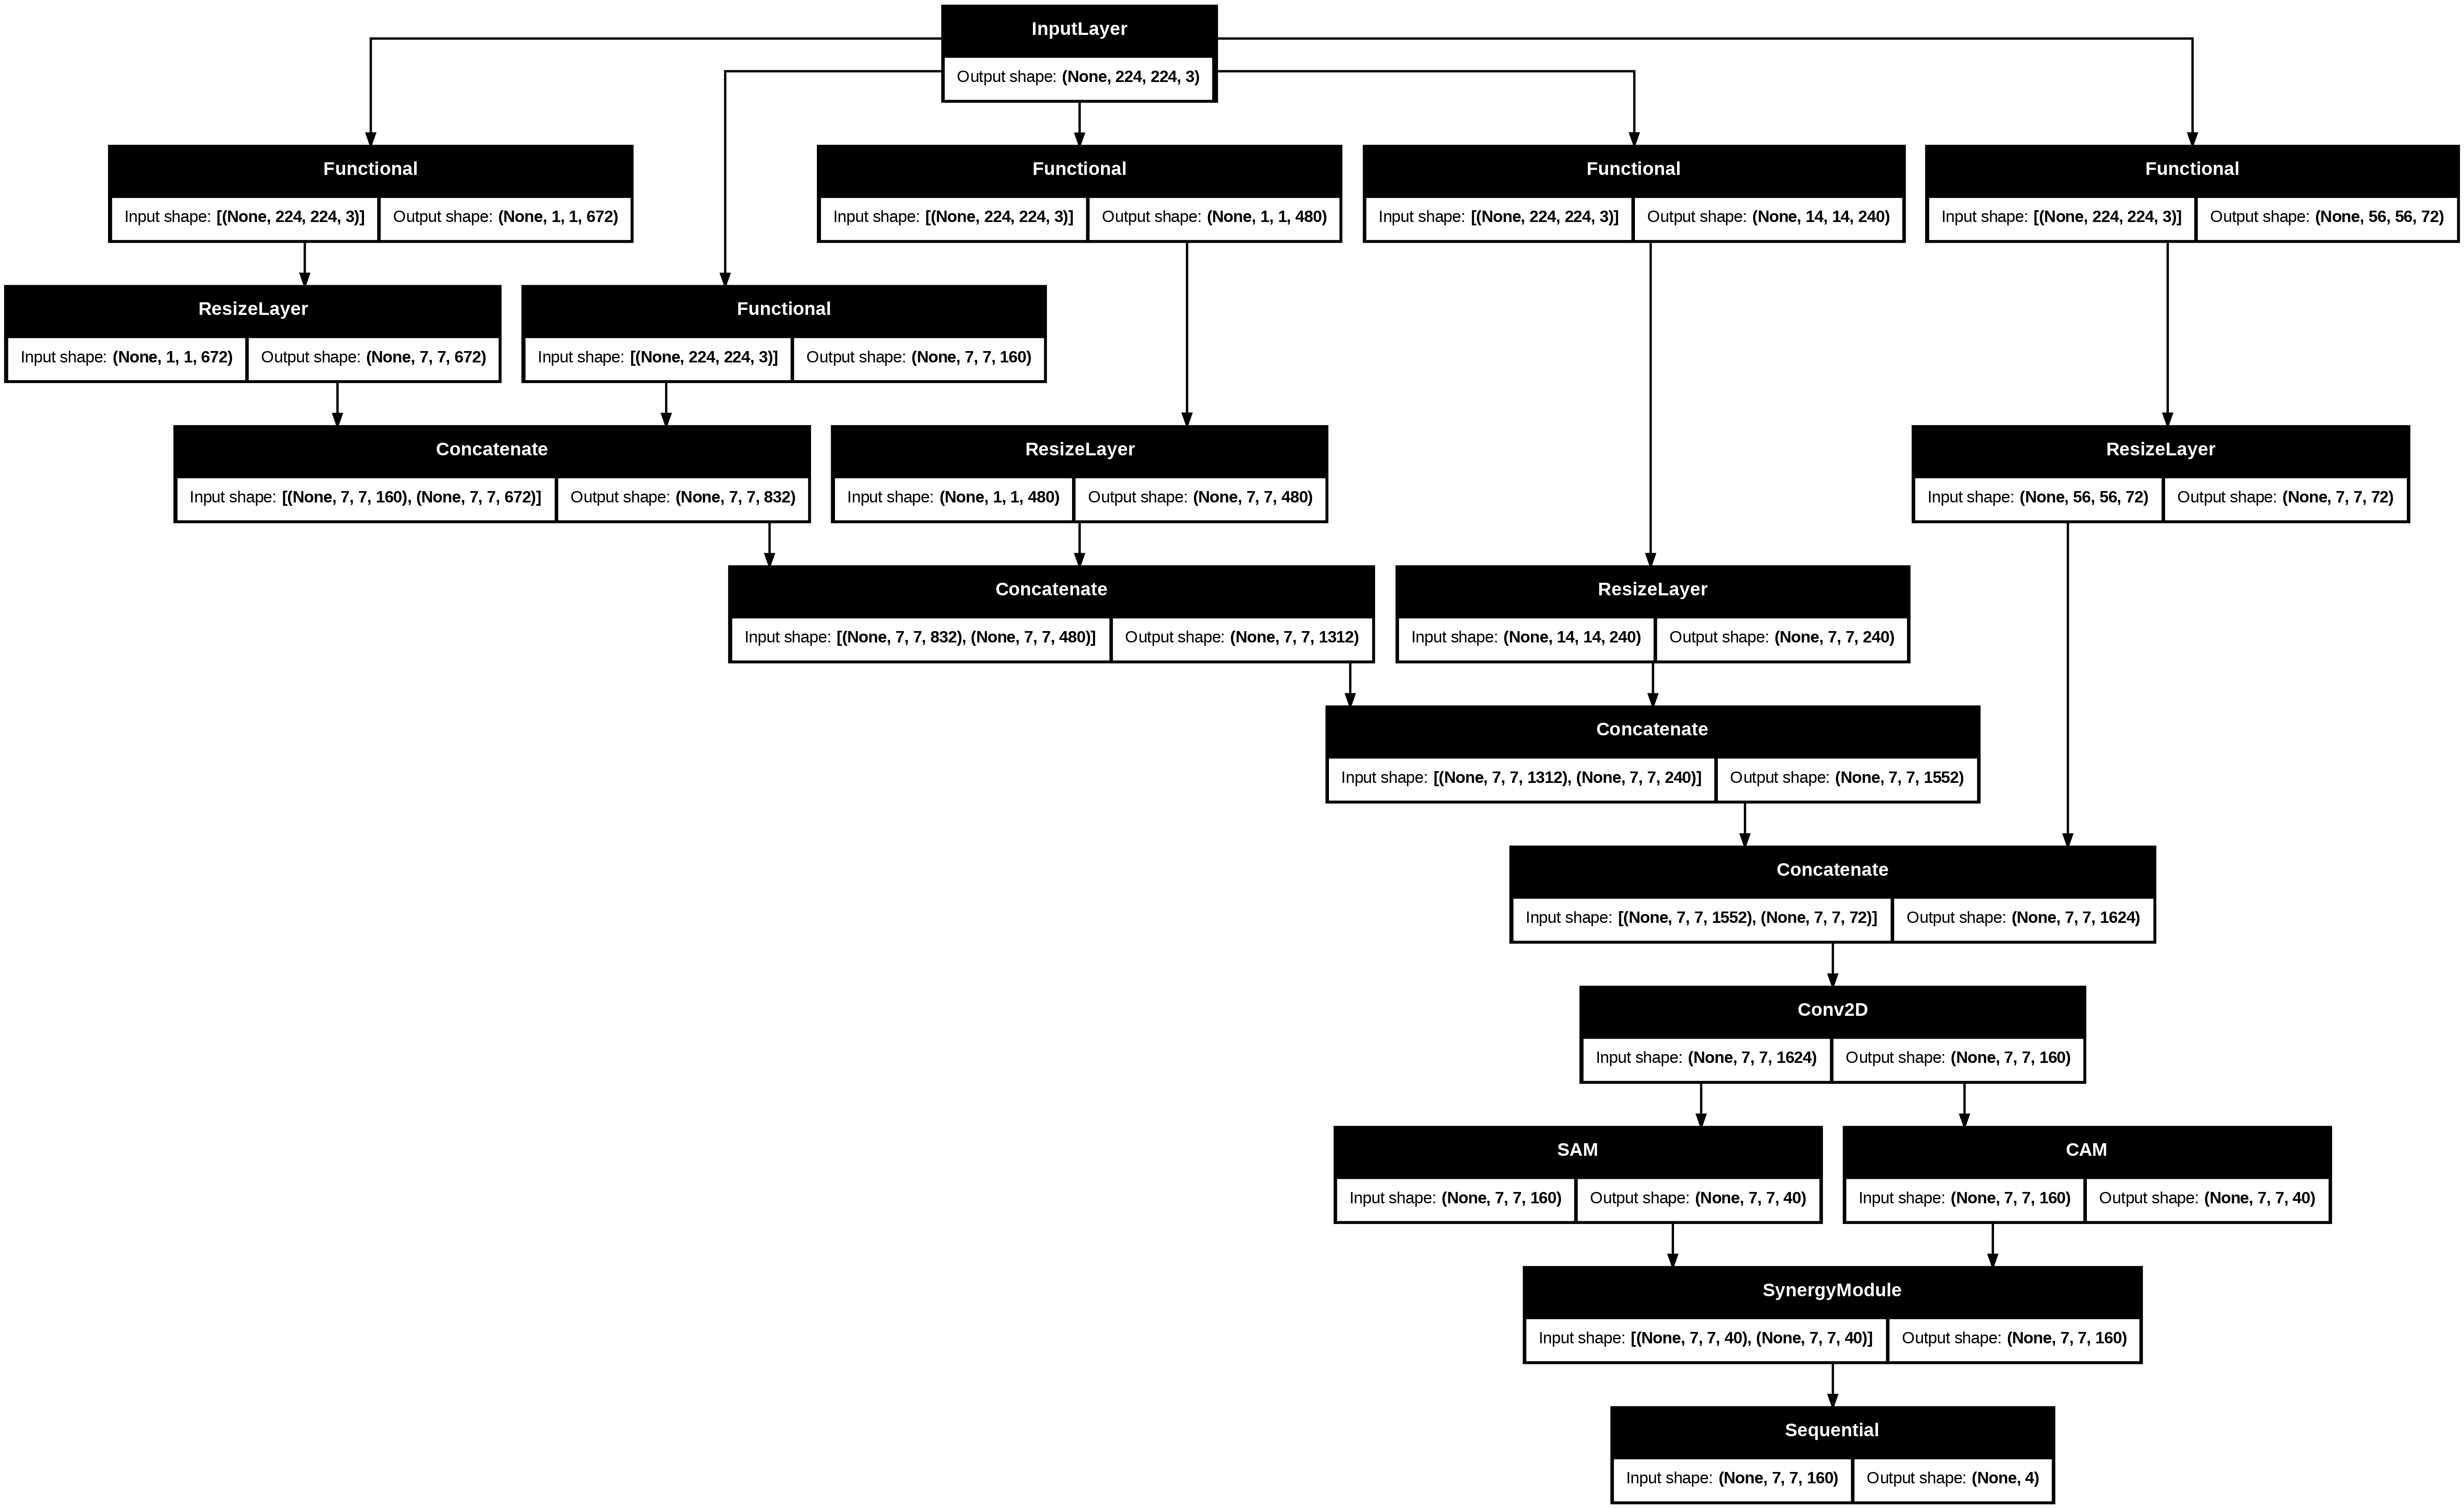

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True)

# 4. Training

In [ ]:
start_time = time.time()
num_epochs = 35

# Callbacks
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir="logs", histogram_freq=1, write_graph=True, profile_batch=0
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.7,  # Smaller factor for gentler reduction
    patience=5,  # More patience before reducing
    min_lr=1e-7,
    verbose=1,
)

# Add a learning rate warmup at the beginning
warmup_lr = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch, lr: initial_learning_rate * min(1, (epoch + 1) / 3)
    if epoch < 3
    else lr
)

checkpoint = ModelCheckpoint(
    "best_model.keras", monitor="val_loss", save_best_only=True, mode="min"
)


# Compute class weights
def get_class_weights(y):
    class_weights = compute_class_weight(
        class_weight="balanced", classes=np.unique(y), y=y
    )
    return dict(enumerate(class_weights))


# Calculate balanced class weights
class_weights = compute_class_weight(
    "balanced", classes=np.unique(tr_gen.classes), y=tr_gen.classes
)

class_weight_dict = dict(enumerate(class_weights))

# Use in training
hist = model.fit(
    tr_gen,
    epochs=num_epochs,
    validation_data=valid_gen,
    shuffle=True,
    callbacks=[early_stopping, tensorboard_callback, reduce_lr, warmup_lr, checkpoint],
)

Epoch 1/35
179/179 ━━━━━━━━━━━━━━━━━━━━ 154s 660ms/step - accuracy: 0.4833 - auc: 0.7457 - loss: 1.1813 - precision: 0.8371 - recall: 0.1261 - val_accuracy: 0.3084 - val_auc: 0.5745 - val_loss: 2.2577 - val_precision: 0.3043 - val_recall: 0.2992 - learning_rate: 1.6667e-05
Epoch 2/35
179/179 ━━━━━━━━━━━━━━━━━━━━ 101s 545ms/step - accuracy: 0.7718 - auc: 0.9376 - loss: 0.6467 - precision: 0.8394 - recall: 0.6593 - val_accuracy: 0.3145 - val_auc: 0.6342 - val_loss: 2.1996 - val_precision: 0.3207 - val_recall: 0.2977 - learning_rate: 3.3333e-05
Epoch 3/35
179/179 ━━━━━━━━━━━━━━━━━━━━ 99s 533ms/step - accuracy: 0.8625 - auc: 0.9721 - loss: 0.4111 - precision: 0.8872 - recall: 0.8225 - val_accuracy: 0.4855 - val_auc: 0.7602 - val_loss: 1.5160 - val_precision: 0.5092 - val_recall: 0.4656 - learning_rate: 5.0000e-05
Epoch 4/35
179/179 ━━━━━━━━━━━━━━━━━━━━ 99s 534ms/step - accuracy: 0.9055 - auc: 0.9853 - loss: 0.2918 - precision: 0.9189 - recall: 0.8876 - val_accuracy: 0.6000 - val_auc: 0.857

In [18]:
end_time = time.time()
training_duration = end_time - start_time

# Print duration in hours, minutes, and seconds
hours = int(training_duration // 3600)
minutes = int((training_duration % 3600) // 60)
seconds = int(training_duration % 60)
print(f"\nTotal training time: {hours:02d}:{minutes:02d}:{seconds:02d}")


Total training time: 00:27:32


In [19]:
hist.history.keys()

dict_keys(['accuracy', 'auc', 'loss', 'precision', 'recall', 'val_accuracy', 'val_auc', 'val_loss', 'val_precision', 'val_recall', 'learning_rate'])

## 4.1 Visualize model performance

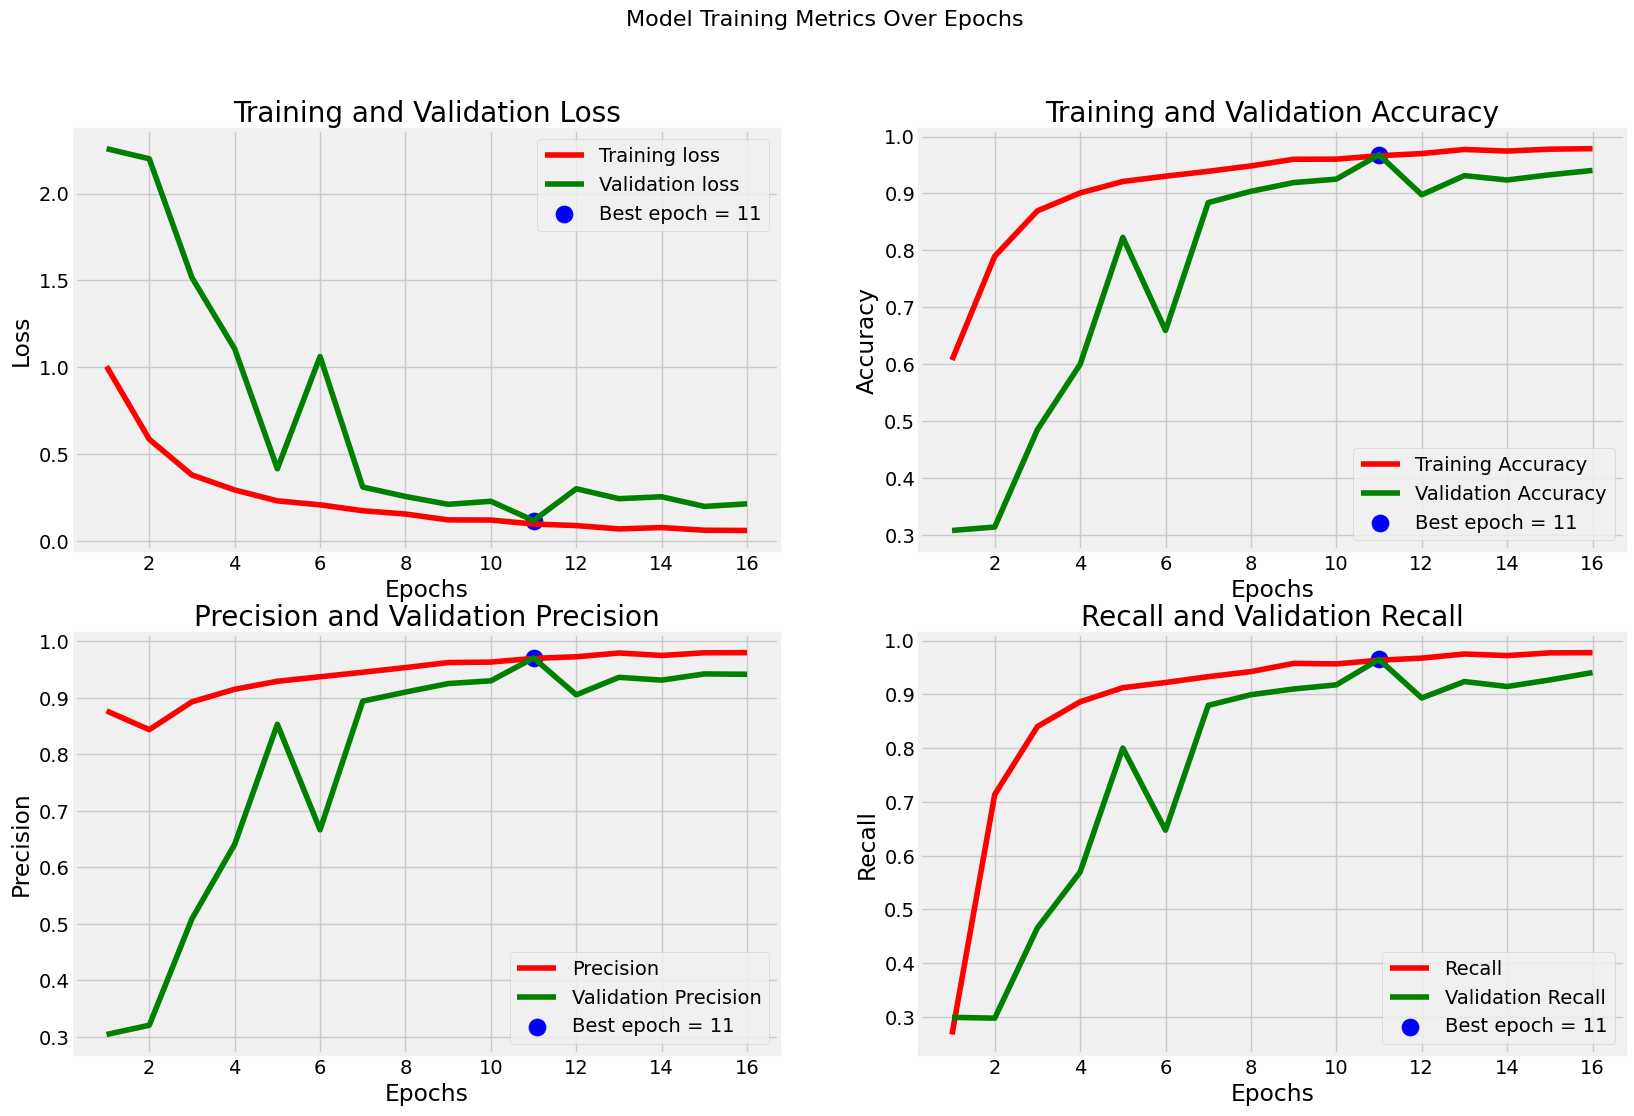

In [ ]:
tr_acc = hist.history["accuracy"]
tr_loss = hist.history["loss"]
tr_per = hist.history["precision"]
tr_recall = hist.history["recall"]
val_acc = hist.history["val_accuracy"]
val_loss = hist.history["val_loss"]
val_per = hist.history["val_precision"]
val_recall = hist.history["val_recall"]

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f"Best epoch = {str(index_loss + 1)}"
acc_label = f"Best epoch = {str(index_acc + 1)}"
per_label = f"Best epoch = {str(index_precision + 1)}"
recall_label = f"Best epoch = {str(index_recall + 1)}"


plt.figure(figsize=(20, 12))
plt.style.use("fivethirtyeight")


plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, "r", label="Training loss")
plt.plot(Epochs, val_loss, "g", label="Validation loss")
plt.scatter(index_loss + 1, val_lowest, s=150, c="blue", label=loss_label)
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, "r", label="Training Accuracy")
plt.plot(Epochs, val_acc, "g", label="Validation Accuracy")
plt.scatter(index_acc + 1, acc_highest, s=150, c="blue", label=acc_label)
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, "r", label="Precision")
plt.plot(Epochs, val_per, "g", label="Validation Precision")
plt.scatter(index_precision + 1, per_highest, s=150, c="blue", label=per_label)
plt.title("Precision and Validation Precision")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, "r", label="Recall")
plt.plot(Epochs, val_recall, "g", label="Validation Recall")
plt.scatter(index_recall + 1, recall_highest, s=150, c="blue", label=recall_label)
plt.title("Recall and Validation Recall")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.legend()
plt.grid(True)

plt.suptitle("Model Training Metrics Over Epochs", fontsize=16)
plt.show()

# 5. Testing and Evaluation

## 5.1 Evaluate

In [ ]:
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1] * 100:.2f}%")
print("-" * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1] * 100:.2f}%")
print("-" * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1] * 100:.2f}%")

179/179 ━━━━━━━━━━━━━━━━━━━━ 77s 429ms/step - accuracy: 0.9784 - auc: 0.9985 - loss: 0.0720 - precision: 0.9806 - recall: 0.9762
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 418ms/step - accuracy: 0.9655 - auc: 0.9985 - loss: 0.1011 - precision: 0.9674 - recall: 0.9646
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 181ms/step - accuracy: 0.9706 - auc: 0.9981 - loss: 0.0999 - precision: 0.9794 - recall: 0.9681
Train Loss: 0.0682
Train Accuracy: 97.81%
--------------------
Validation Loss: 0.1088
Validation Accuracy: 96.34%
--------------------
Test Loss: 0.0902
Test Accuracy: 97.26%


In [22]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 273ms/step


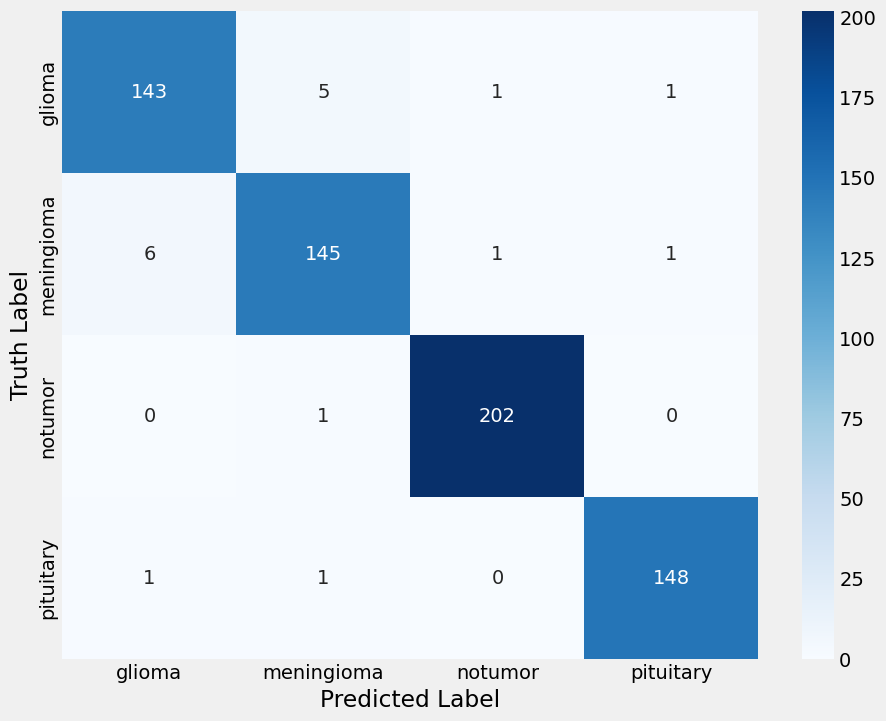

In [ ]:
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels
)
plt.xlabel("Predicted Label")
plt.ylabel("Truth Label")
plt.show()

In [24]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       150
           1       0.95      0.95      0.95       153
           2       0.99      1.00      0.99       203
           3       0.99      0.99      0.99       150

    accuracy                           0.97       656
   macro avg       0.97      0.97      0.97       656
weighted avg       0.97      0.97      0.97       656



## 5.2 Testing

In [ ]:
# Prediction function with TTA
def predict_with_tta(model, img_path, num_augmentations=5):
    img = Image.open(img_path)
    resized_img = img.resize(IMAGE_SIZE)
    img_array = np.asarray(resized_img)

    # Create augmented versions
    predictions = []
    aug = get_augmentation()

    # Original prediction
    base_pred = model.predict(np.expand_dims(img_array, 0) / 255.0)
    predictions.append(base_pred)

    # Augmented predictions
    for _ in range(num_augmentations):
        aug_img = aug.random_transform(img_array)
        aug_pred = model.predict(np.expand_dims(aug_img, 0) / 255.0)
        predictions.append(aug_pred)

    # Average predictions
    return np.mean(predictions, axis=0)


def predict(img_path):
    plt.figure(figsize=(12, 12))
    img = Image.open(img_path)
    resized_img = img.resize(IMAGE_SIZE)

    # Use TTA for prediction
    predictions = predict_with_tta(model, img_path)
    probs = list(predictions[0])
    labels = classes

    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.title("Input Image", fontsize=15)
    plt.axis("off")

    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel("Probability", fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt="%.2f")
    plt.title("Class Probabilities", fontsize=15)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


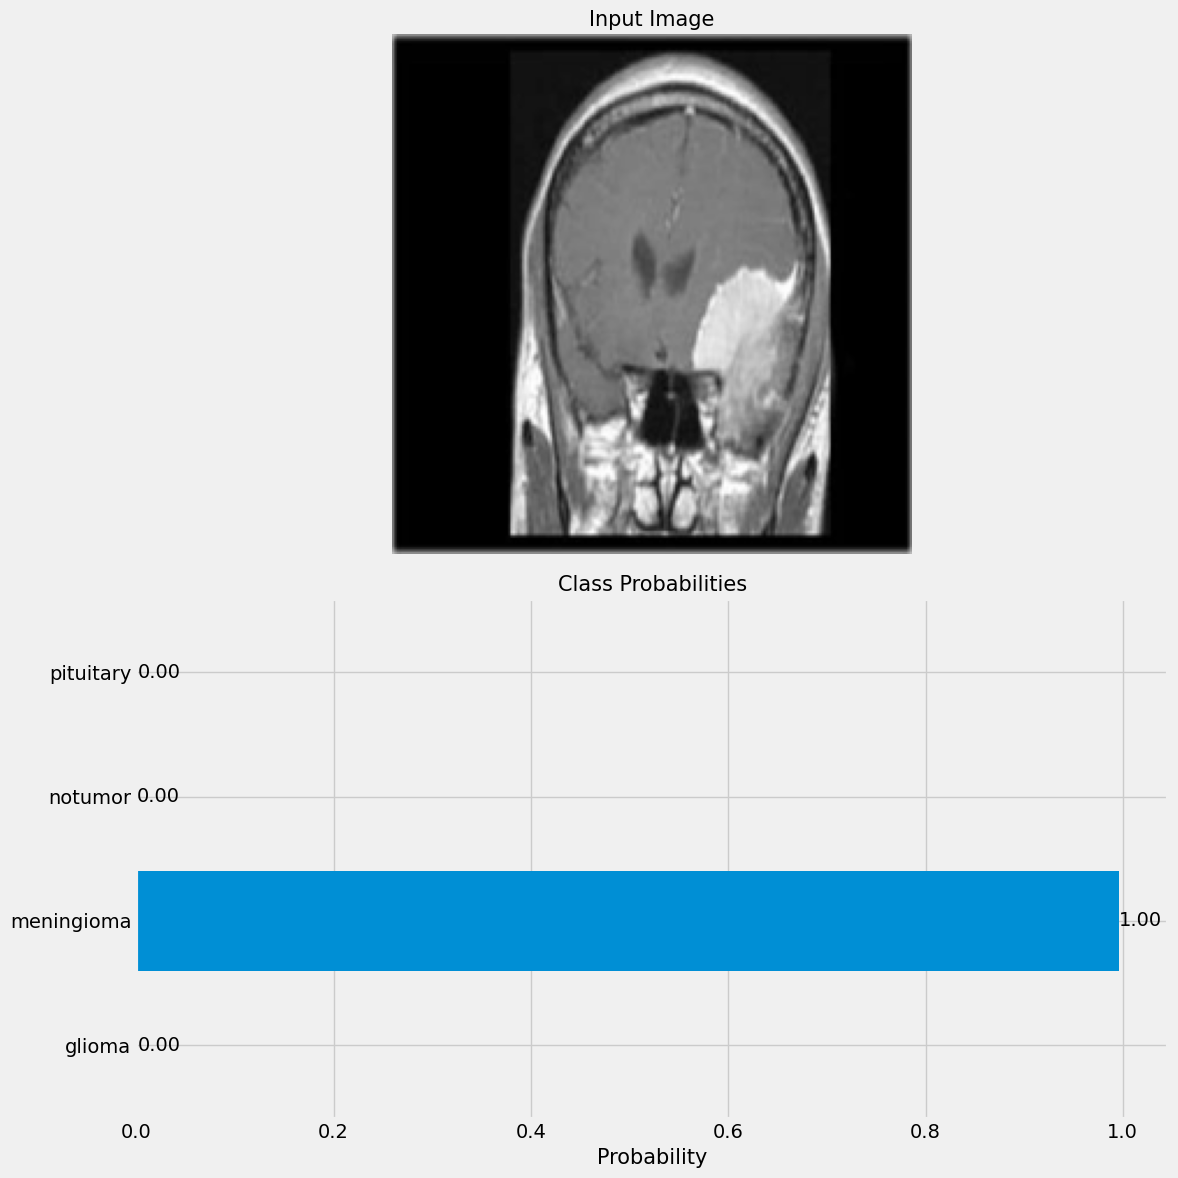

In [ ]:
predict("/kaggle/input/Testing/meningioma/Te-meTr_0000.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


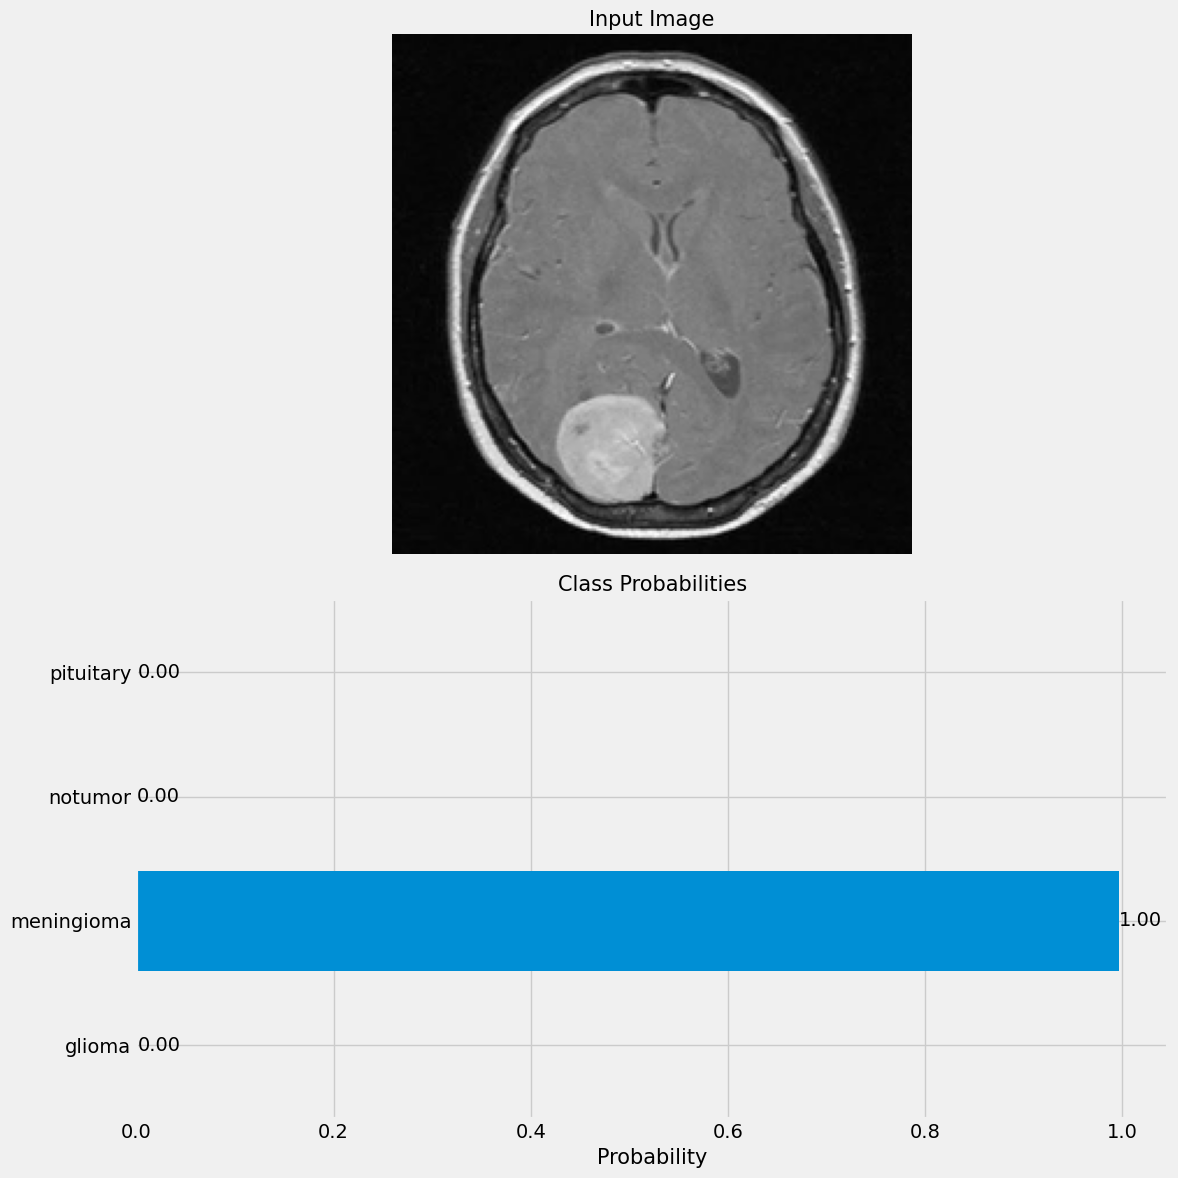

In [ ]:
predict("/kaggle/input/Testing/meningioma/Te-me_0010.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


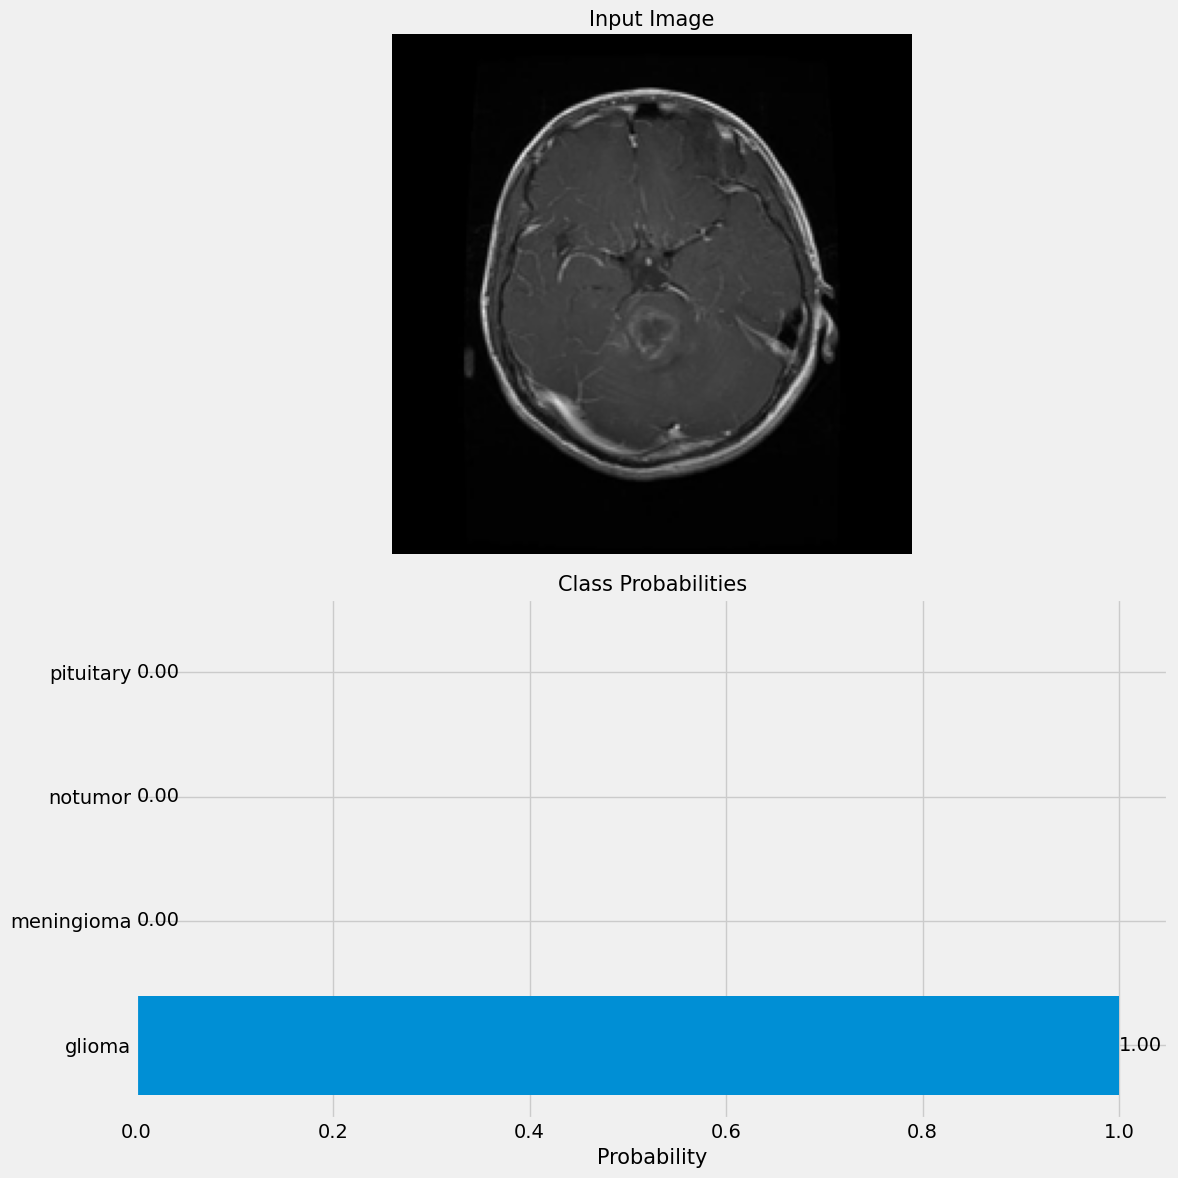

In [ ]:
predict("/kaggle/input/Testing/glioma/Te-glTr_0007.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


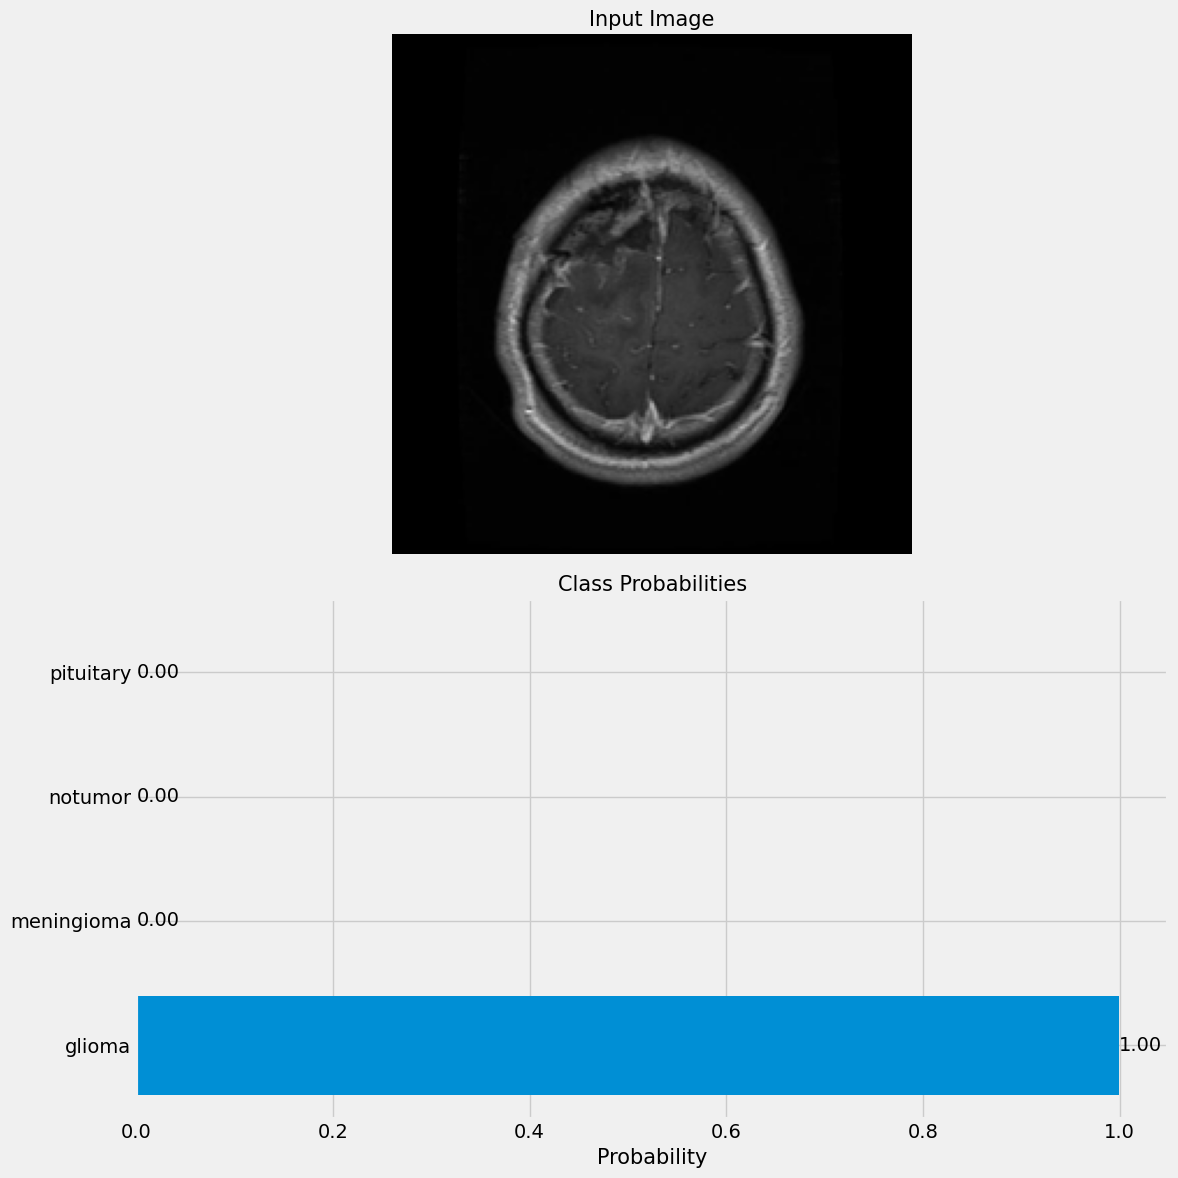

In [ ]:
predict("/kaggle/input/Testing/glioma/Te-gl_0017.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


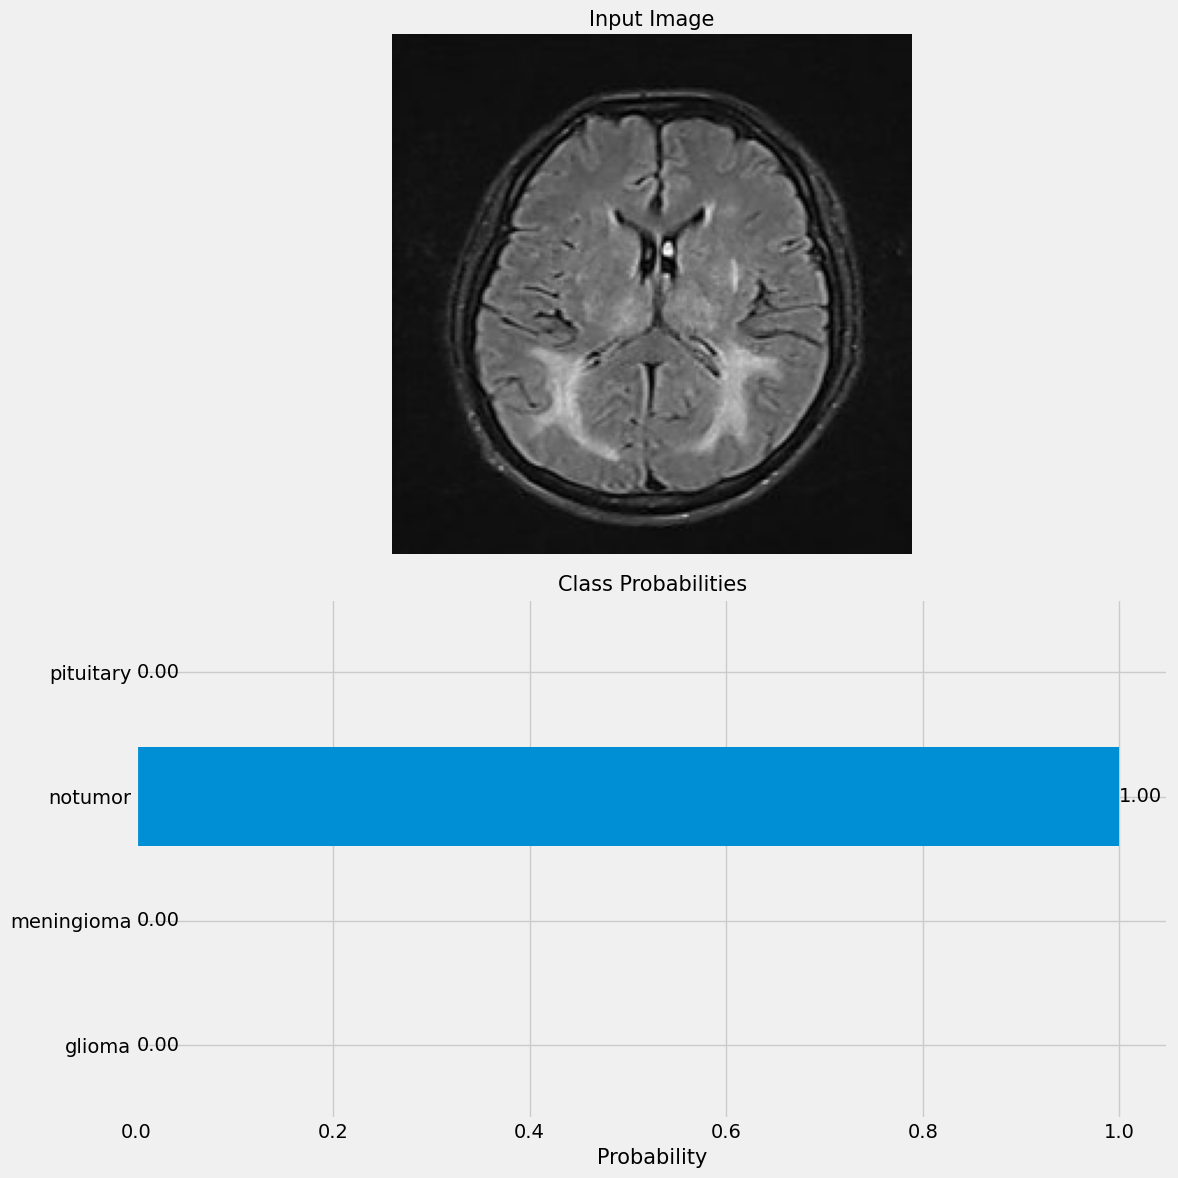

In [ ]:
predict("/kaggle/input/Testing/notumor/Te-noTr_0001.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


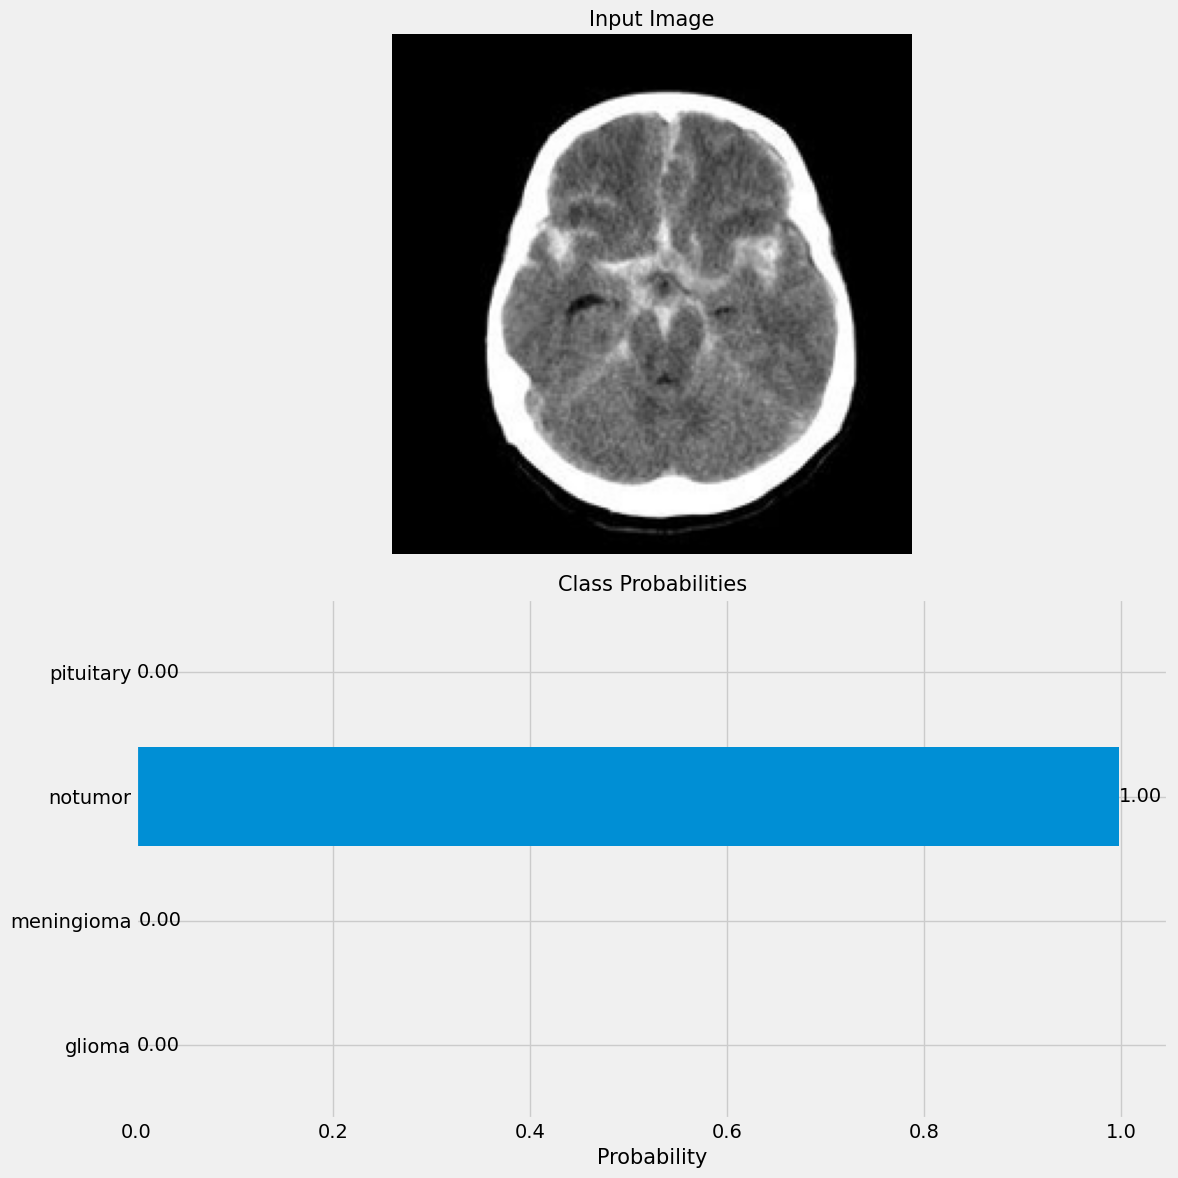

In [ ]:
predict("/kaggle/input/Testing/notumor/Te-no_0011.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


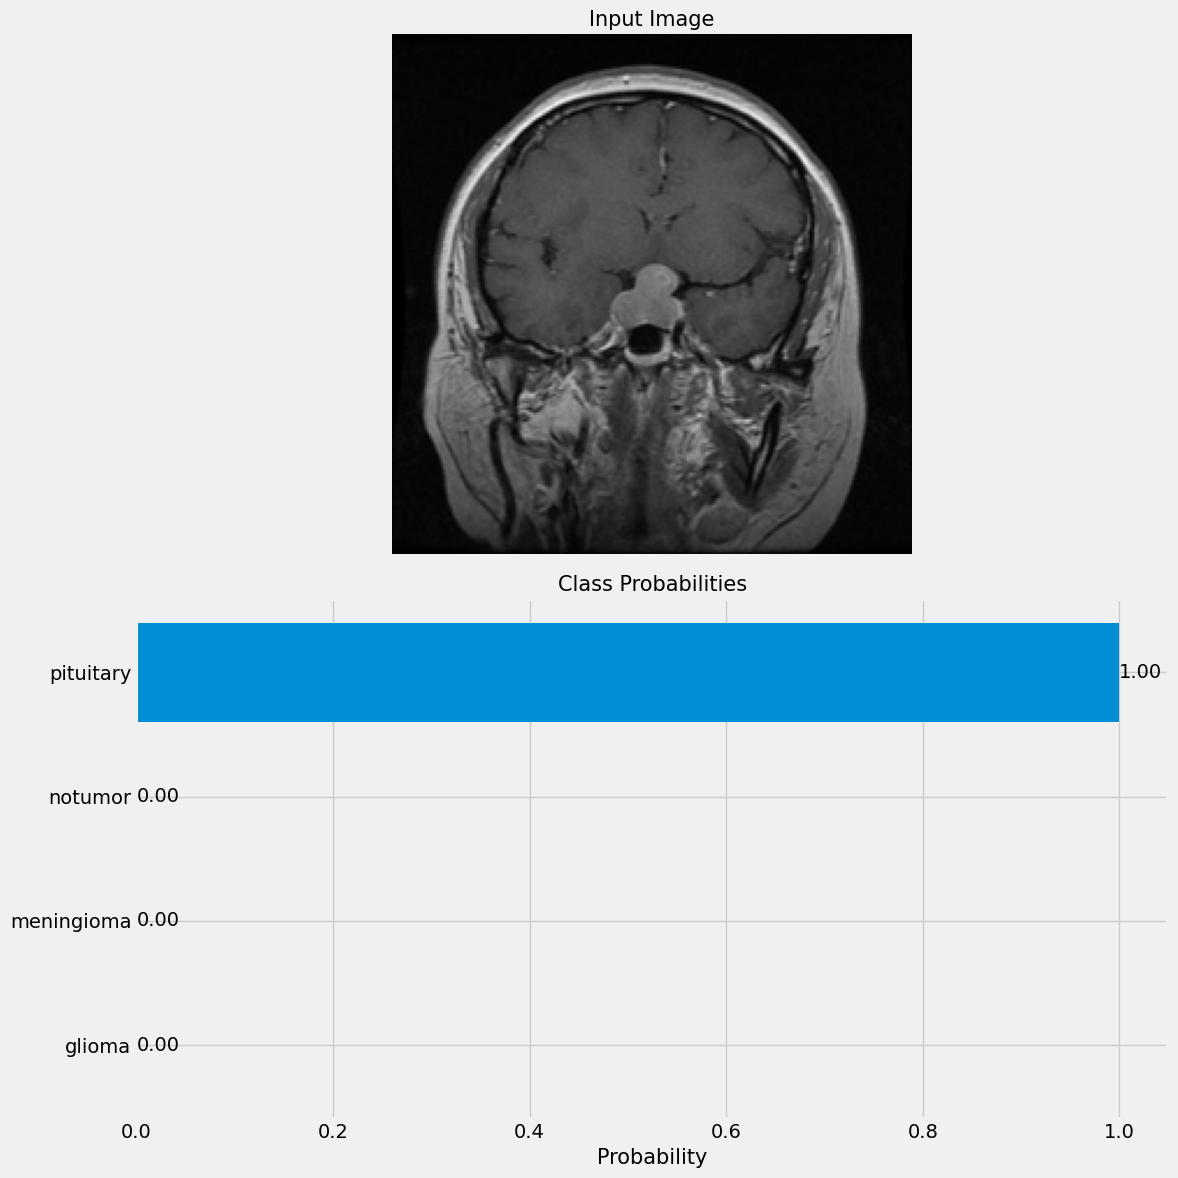

In [ ]:
predict("/kaggle/input/Testing/pituitary/Te-piTr_0001.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


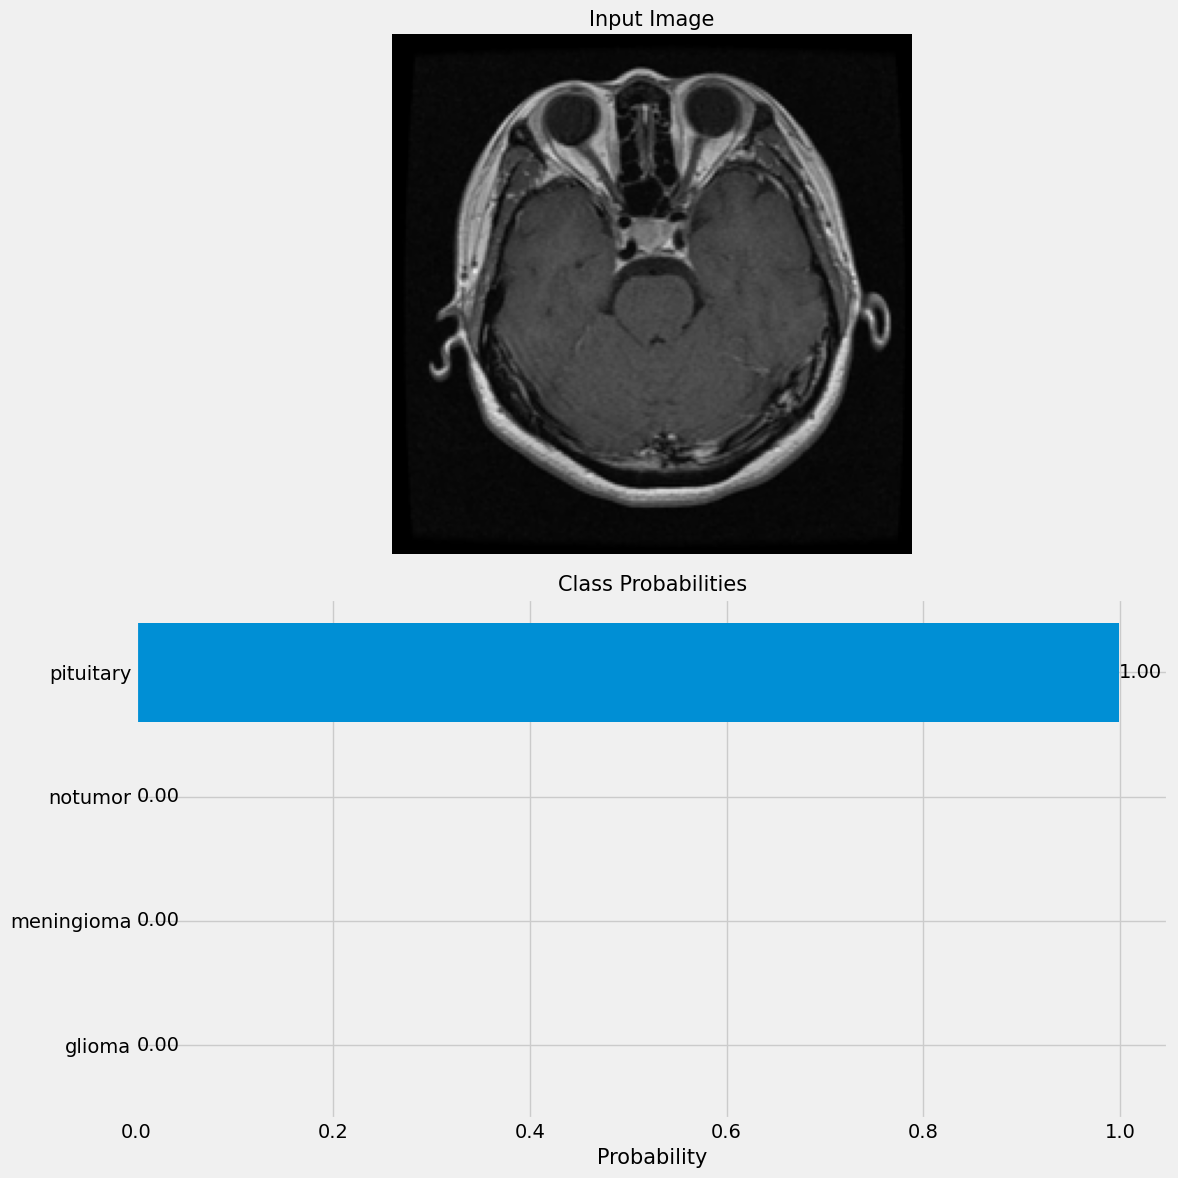

In [ ]:
predict("/kaggle/input/Testing/pituitary/Te-pi_0011.jpg")